In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
df_drop = pd.read_csv('files/missing_drop.csv')

In [14]:
df_sample = df_drop.sample(n=1000, random_state=42)

In [15]:
def perform_pca_analysis(data, target_col=None, max_components=None):
    """
    데이터에 대해 PCA 분석을 수행하고 시각화하는 함수
    
    Parameters:
    data (pandas.DataFrame): 분석할 데이터프레임
    target_col (str): 종속변수 컬럼명 (선택사항)
    max_components (int): 최대 주성분 개수 (기본값: None - 모든 컴포넌트 사용)
    """
    # 원본 데이터 복사하지 않고 참조만 하기
    print("전처리 시작...")
    
    # 숫자형 컬럼만 선택
    numeric_columns = data.select_dtypes(include=['int64', 'float64']).columns
    print(f"\n숫자형 컬럼 수: {len(numeric_columns)}")
    non_numeric = set(data.columns) - set(numeric_columns)
    if non_numeric:
        print("제외된 컬럼들:")
        print(non_numeric)
    
    # 타겟 변수 처리
    if target_col is not None:
        if target_col not in data.columns:
            raise ValueError(f"타겟 컬럼 '{target_col}'이 데이터프레임에 없습니다.")
        y = data[target_col]
        if target_col in numeric_columns:
            numeric_columns = numeric_columns.drop(target_col)
    else:
        y = None
    
    # 숫자형 데이터만 선택
    X = data[numeric_columns]
    
    # 결측치 확인
    null_counts = X.isnull().sum()
    null_columns = null_counts[null_counts > 0]
    if not null_columns.empty:
        print("\n결측치가 있는 컬럼들:")
        print(null_columns)
        print("\n결측치가 있는 행 제거...")
        X = X.dropna()
        if y is not None:
            y = y[X.index]
    
    print(f"\n분석에 사용될 최종 데이터 크기: {X.shape}")
    
    # 데이터 스케일링
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(X)
    
    # PCA 수행
    if max_components:
        n_components = min(max_components, X.shape[1])
    else:
        n_components = X.shape[1]
        
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(scaled_data)
    
    # 설명된 분산 비율 계산
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
    
    # 시각화
    fig = plt.figure(figsize=(15, 5))
    
    # 1. Scree Plot
    plt.subplot(131)
    plt.plot(range(1, len(explained_variance_ratio) + 1), 
            explained_variance_ratio, 'bo-')
    plt.title('Scree Plot')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    
    # 2. 누적 분산 설명률
    plt.subplot(132)
    plt.plot(range(1, len(cumulative_variance_ratio) + 1),
            cumulative_variance_ratio, 'ro-')
    plt.axhline(y=0.8, color='k', linestyle='--')
    plt.title('Cumulative Explained Variance Ratio')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    
    # 3. Biplot (처음 두 개의 주성분)
    plt.subplot(133)
    if y is not None:
        scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=y, cmap='viridis')
        plt.colorbar(scatter, label=target_col)
    else:
        plt.scatter(pca_result[:, 0], pca_result[:, 1])
    plt.title('PCA Biplot (PC1 vs PC2)')
    plt.xlabel(f'PC1 ({explained_variance_ratio[0]:.2%})')
    plt.ylabel(f'PC2 ({explained_variance_ratio[1]:.2%})')
    
    plt.tight_layout()
    plt.show()
    
    # 주요 성분들의 변수 기여도 분석 (상위 3개만)
    n_components_heatmap = min(3, len(X.columns))
    component_df = pd.DataFrame(
        pca.components_[:n_components_heatmap].T,
        columns=[f'PC{i+1}' for i in range(n_components_heatmap)],
        index=X.columns
    )
    
    # 히트맵으로 변수 기여도 시각화
    plt.figure(figsize=(12, 8))
    sns.heatmap(component_df, cmap='coolwarm', center=0)
    plt.title('Variable Contributions to Principal Components')
    plt.show()
    
    # 주요 성분별 상위 기여 변수 출력
    print("\n각 주성분별 상위 기여 변수 (절대값 기준)")
    for i in range(n_components_heatmap):
        pc_loadings = pd.Series(
            pca.components_[i],
            index=X.columns
        )
        print(f"\nPC{i+1} 상위 10개 변수:")
        print(pc_loadings.abs().sort_values(ascending=False).head(10))
    
    return {
        'pca_model': pca,
        'pca_result': pca_result,
        'explained_variance_ratio': explained_variance_ratio,
        'component_df': component_df,
        'processed_features': list(X.columns)
    }

In [16]:
def perform_mds_analysis(data, n_components=2, target_col=None):
    """
    데이터에 대해 MDS 분석을 수행하고 시각화하는 함수
    
    Parameters:
    data (pandas.DataFrame): 분석할 데이터프레임
    n_components (int): MDS 차원 수 (기본값: 2)
    target_col (str): 종속변수 컬럼명 (선택사항)
    """
    print("전처리 시작...")
    
    # 숫자형 컬럼만 선택
    numeric_columns = data.select_dtypes(include=['int64', 'float64']).columns
    print(f"\n숫자형 컬럼 수: {len(numeric_columns)}")
    non_numeric = set(data.columns) - set(numeric_columns)
    if non_numeric:
        print("제외된 컬럼들:")
        print(non_numeric)
    
    # 타겟 변수 처리
    if target_col is not None:
        if target_col not in data.columns:
            raise ValueError(f"타겟 컬럼 '{target_col}'이 데이터프레임에 없습니다.")
        y = data[target_col]
        if target_col in numeric_columns:
            numeric_columns = numeric_columns.drop(target_col)
    else:
        y = None
    
    # 숫자형 데이터만 선택
    X = data[numeric_columns]
    
    # 결측치 확인
    null_counts = X.isnull().sum()
    null_columns = null_counts[null_counts > 0]
    if not null_columns.empty:
        print("\n결측치가 있는 컬럼들:")
        print(null_columns)
        print("\n결측치가 있는 행 제거...")
        X = X.dropna()
        if y is not None:
            y = y[X.index]
    
    print(f"\n분석에 사용될 최종 데이터 크기: {X.shape}")
    
    # 데이터 스케일링
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(X)
    
    # MDS 수행
    mds = MDS(n_components=n_components, random_state=42)
    mds_coords = mds.fit_transform(scaled_data)
    
    # Stress value 출력
    print(f"\nMDS Stress: {mds.stress_:.2f}")
    print("(낮을수록 원본 데이터의 거리 관계가 잘 보존됨)")
    
    # 시각화
    plt.figure(figsize=(10, 8))
    
    if y is not None:
        scatter = plt.scatter(mds_coords[:, 0], mds_coords[:, 1], c=y, cmap='viridis')
        plt.colorbar(scatter, label=target_col)
    else:
        plt.scatter(mds_coords[:, 0], mds_coords[:, 1])
    
    plt.title('MDS Visualization')
    plt.xlabel('First MDS Dimension')
    plt.ylabel('Second MDS Dimension')
    plt.show()
    
    # 거리 행렬과 MDS 거리의 상관관계 시각화
    original_dist = np.sqrt(np.sum((scaled_data[:, None, :] - 
                                  scaled_data[None, :, :]) ** 2, axis=2))
    mds_dist = np.sqrt(np.sum((mds_coords[:, None, :] - 
                              mds_coords[None, :, :]) ** 2, axis=2))
    
    plt.figure(figsize=(8, 8))
    plt.scatter(original_dist.flatten(), mds_dist.flatten(), alpha=0.1)
    plt.xlabel('Original Distances')
    plt.ylabel('MDS Distances')
    plt.title('Original vs MDS Distances')
    
    # 대각선 그리기
    min_val = min(original_dist.min(), mds_dist.min())
    max_val = max(original_dist.max(), mds_dist.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    plt.show()
    
    return {
        'mds_model': mds,
        'mds_coords': mds_coords,
        'stress': mds.stress_,
        'processed_features': list(X.columns)
    }

# 사용 예시
"""
# 기본 실행
results = perform_mds_analysis(df)

# 3차원으로 실행
results = perform_mds_analysis(df, n_components=3)

# 종속변수 지정
results = perform_mds_analysis(df, target_col='target')
"""

"\n# 기본 실행\nresults = perform_mds_analysis(df)\n\n# 3차원으로 실행\nresults = perform_mds_analysis(df, n_components=3)\n\n# 종속변수 지정\nresults = perform_mds_analysis(df, target_col='target')\n"

전처리 시작...

숫자형 컬럼 수: 61
제외된 컬럼들:
{'ORGANIZATION_TYPE', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'CODE_GENDER', 'WEEKDAY_APPR_PROCESS_START', 'NAME_TYPE_SUITE', 'FLAG_OWN_REALTY', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'NAME_INCOME_TYPE', 'FLAG_OWN_CAR', 'NAME_FAMILY_STATUS'}

분석에 사용될 최종 데이터 크기: (167732, 60)


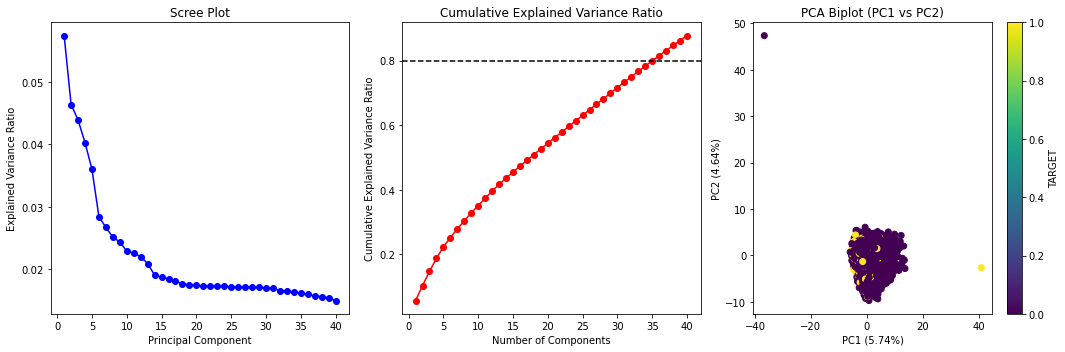

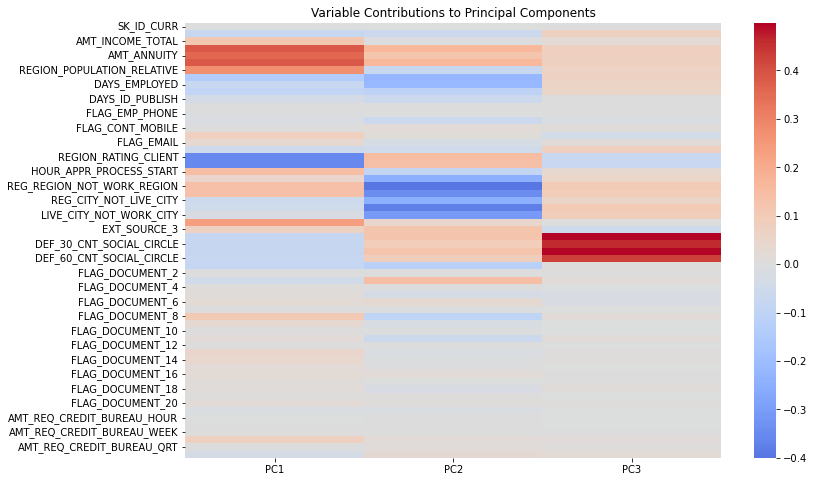


각 주성분별 상위 기여 변수 (절대값 기준)

PC1 상위 10개 변수:
AMT_GOODS_PRICE                0.386905
AMT_CREDIT                     0.383996
AMT_ANNUITY                    0.359555
REGION_RATING_CLIENT_W_CITY    0.354844
REGION_RATING_CLIENT           0.353124
REGION_POPULATION_RELATIVE     0.273703
EXT_SOURCE_2                   0.231878
HOUR_APPR_PROCESS_START        0.146533
DAYS_BIRTH                     0.142800
LIVE_REGION_NOT_WORK_REGION    0.138818
dtype: float64

PC2 상위 10개 변수:
REG_REGION_NOT_WORK_REGION     0.400117
REG_CITY_NOT_WORK_CITY         0.377356
LIVE_REGION_NOT_WORK_REGION    0.341256
LIVE_CITY_NOT_WORK_CITY        0.306143
REG_REGION_NOT_LIVE_REGION     0.246906
REG_CITY_NOT_LIVE_CITY         0.245844
DAYS_BIRTH                     0.221900
DAYS_EMPLOYED                  0.215916
AMT_CREDIT                     0.165693
AMT_GOODS_PRICE                0.163189
dtype: float64

PC3 상위 10개 변수:
OBS_60_CNT_SOCIAL_CIRCLE       0.498195
OBS_30_CNT_SOCIAL_CIRCLE       0.497422
DEF_30_CNT_SOCIA

In [17]:
result1 = perform_pca_analysis(df_drop, 'TARGET', 40)

전처리 시작...

숫자형 컬럼 수: 61
제외된 컬럼들:
{'ORGANIZATION_TYPE', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'CODE_GENDER', 'WEEKDAY_APPR_PROCESS_START', 'NAME_TYPE_SUITE', 'FLAG_OWN_REALTY', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'NAME_INCOME_TYPE', 'FLAG_OWN_CAR', 'NAME_FAMILY_STATUS'}

분석에 사용될 최종 데이터 크기: (1000, 60)

MDS Stress: 4548768.15
(낮을수록 원본 데이터의 거리 관계가 잘 보존됨)


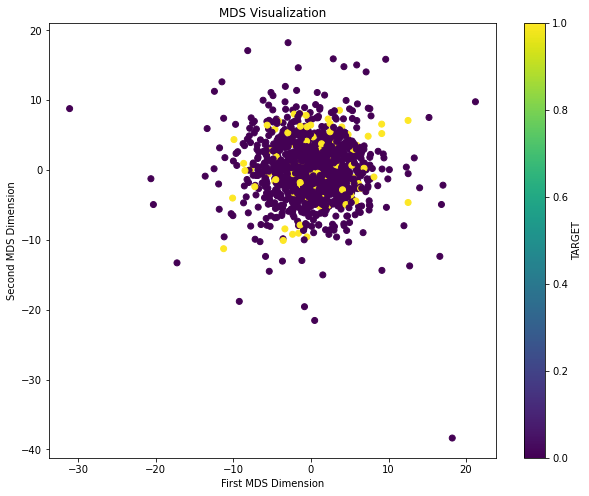

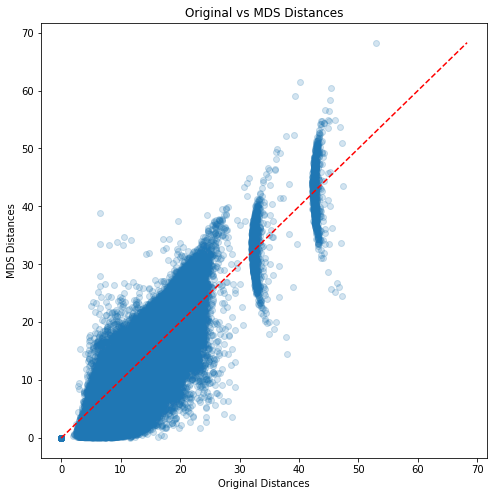

In [19]:
result2 = perform_mds_analysis(df_sample, 2, 'TARGET')